In [5]:
!pip install -q pyreadr

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle
import joblib
import time
from skorch import NeuralNetRegressor
from torch import nn
import torch
from sklearn import svm
import os

In [9]:
import pandas as pd
import pyreadr
result = pyreadr.read_r('../../scotus/data/scotus_filtered.rda')
scotus_df = result["scotus_filtered"]

In [1]:
# for line in [f'{f[:-4]}_df = pd.read_csv("scotus/{f}")' for f in os.listdir("scotus") if f.endswith("csv")]:
#     print(line)

# print("{")
# for line in [f'\t"{f[:-4]}": {f[:-4]}_df,' for f in os.listdir("scotus") if f.endswith("csv")]:
#     print(line)
# print("}")

In [10]:
bigram_df = pd.read_csv("../features/scotus/bigram.csv")
t5_scotus_embeddings_df = pd.read_csv("../features/scotus/t5_scotus_embeddings.csv")
paraphrase_scotus_embeddings_df = pd.read_csv("../features/scotus/paraphrase_scotus_embeddings.csv")
smoothed_unigram_df = pd.read_csv("../features/scotus/smoothed_unigram.csv")
unigram_df = pd.read_csv("../features/scotus/unigram.csv")
tfidf_df = pd.read_csv("../features/scotus/tfidf.csv")

In [11]:
models = {
	"bigram": bigram_df,
	"t5_scotus_embeddings": t5_scotus_embeddings_df,
	"paraphrase_scotus_embeddings": paraphrase_scotus_embeddings_df,
	"smoothed_unigram": smoothed_unigram_df,
	"unigram": unigram_df,
	"tfidf": tfidf_df
}

In [28]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout=0.3):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )

    def forward(self, x):
        return self.model(x)

def get_clf(model_type, n_columns):
    match model_type:
        case "gbt":
            return GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
        case "svm":
            return svm.SVR()
        case "mlp":
            best_model = NeuralNetRegressor(
                MLPRegression,
                module__input_dim=n_columns,
                module__hidden_dim1=1024,
                module__hidden_dim2=256,
                module__dropout=0.5,
                max_epochs=250,
                lr=0.01,
                batch_size=64,
                optimizer=torch.optim.Adam,
                # device=device,
                verbose=1
            )
            return best_model


In [29]:
def train_and_score_gbt(X, y, model_name, dataset_name="scotus", model_type="gbt"):
    # 1. Split Data
    if model_type == "mlp":
        X, y = X.astype('float32'), y.astype('float32').reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    # 2. Train GBT Model
    clf = get_clf(model_type, X.shape[1])
    clf.fit(X_train,y_train)

    # 3. Get Predictions and Residuals
    y_pred = clf.predict(X_test)
    residuals = y_test - y_pred

    # 4. Score
    scores = {
        'model_name': model_name,
        'r2': r2_score(y_pred, y_test),
        'mea': mean_absolute_error(y_pred, y_test),
        'rmse': root_mean_squared_error(y_pred, y_test)
    }

    # 5. Plot
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot: {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    os.mkdir(f"../results/{dataset_name}/{model_name}")
    plt.savefig(f"../results/{dataset_name}/{model_name}/residuals.jpg")
    plt.clf()
    
    # 6. Save Model and Scores
    joblib.dump(clf, f"../results/{dataset_name}/{model_name}/model_object.pkl")
    joblib.dump(clf, f"../results/{dataset_name}/{model_name}/model_scores.pkl")

    return scores

In [30]:
scores_df = pd.DataFrame(columns=['model_name','r2','mea','rmse'])

for (model_name, features_df) in models.items():
    t0 = time.time()
    scores = train_and_score_gbt(
        X=features_df.to_numpy(), 
        y=scotus_df.year.apply(int).to_numpy(),
        model_name=model_name+"_mlp",
        model_type="mlp",
        dataset_name="scotus"
    )
    scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)
    t1 = time.time()
    total = t1-t0
    print(f"Finished {model_name+"_mlp"} in {total} seconds.")
    print(scores_df.head())

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1920263.2030  1364493.9443  0.7034
      2  1190631.2025  1116893.6353  0.8123
      3   981218.2012  1113315.4870  0.7726
      4   804467.8598   787881.6473  0.7712
      5   655161.0511   674074.1250  1.0790
      6   561274.4561   697923.9833  0.9441
      7   487526.9797   522132.9707  0.8627
      8   415599.2878   530236.6005  0.7278
      9   379241.4946   598546.2455  0.9057
     10   333914.3347   435794.5130  0.8485
     11   292695.4233   440129.1582  0.8959
     12   263973.1547   409658.0992  0.9384
     13   248599.2043   363735.4688  0.8095
     14   262448.3233   362559.9362  0.7075
     15   232278.6345   372798.8737  0.8017
     16   203031.7275   343122.5252  0.8440
     17   211054.1186   406213.3877  0.8364
     18   175835.3394   418244.6690  0.8066
     19   182145.9152   408103.7365  0.6982
     20   183051.1720   352646.2801  0.6457
     21   192878.8772   332566.5

/var/folders/g9/m0c3tdxd4l7f9js2h3wz_fp40000gn/T/ipykernel_52542/1028470611.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)


Finished bigram_mlp in 200.51003313064575 seconds.
   model_name        r2         mea        rmse
0  bigram_mlp -0.433479  405.798492  532.316528
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   903539.4180   413493.4345  0.6914
      2   216021.5403    71179.5254  0.7206
      3    88580.5382    61332.5170  0.5760
      4    69825.8188    25966.9267  0.6709
      5    59449.2089    45295.2508  0.6401
      6    56716.2812    32157.0832  0.6507
      7    67252.9384    14316.4749  1.1942
      8    53638.6057    46176.9705  0.6226
      9    53224.2807    18158.8322  0.6570
     10    36490.3857     3517.8592  0.7451
     11    37712.1265     9404.0737  0.6334
     12    42635.4274     4035.9680  0.6693
     13    57689.2445    17583.4636  0.5846
     14    53785.8014    11519.3091  0.5509
     15    45606.3780    11092.5538  0.6829
     16    55176.3391     6665.6351  0.9392
     17    34313.1898     6331.1882  0.8602
     18    33994.

<Figure size 640x480 with 0 Axes>

In [31]:
scores_df.to_csv("../results/scotus/scores_mlp_scotus.csv")

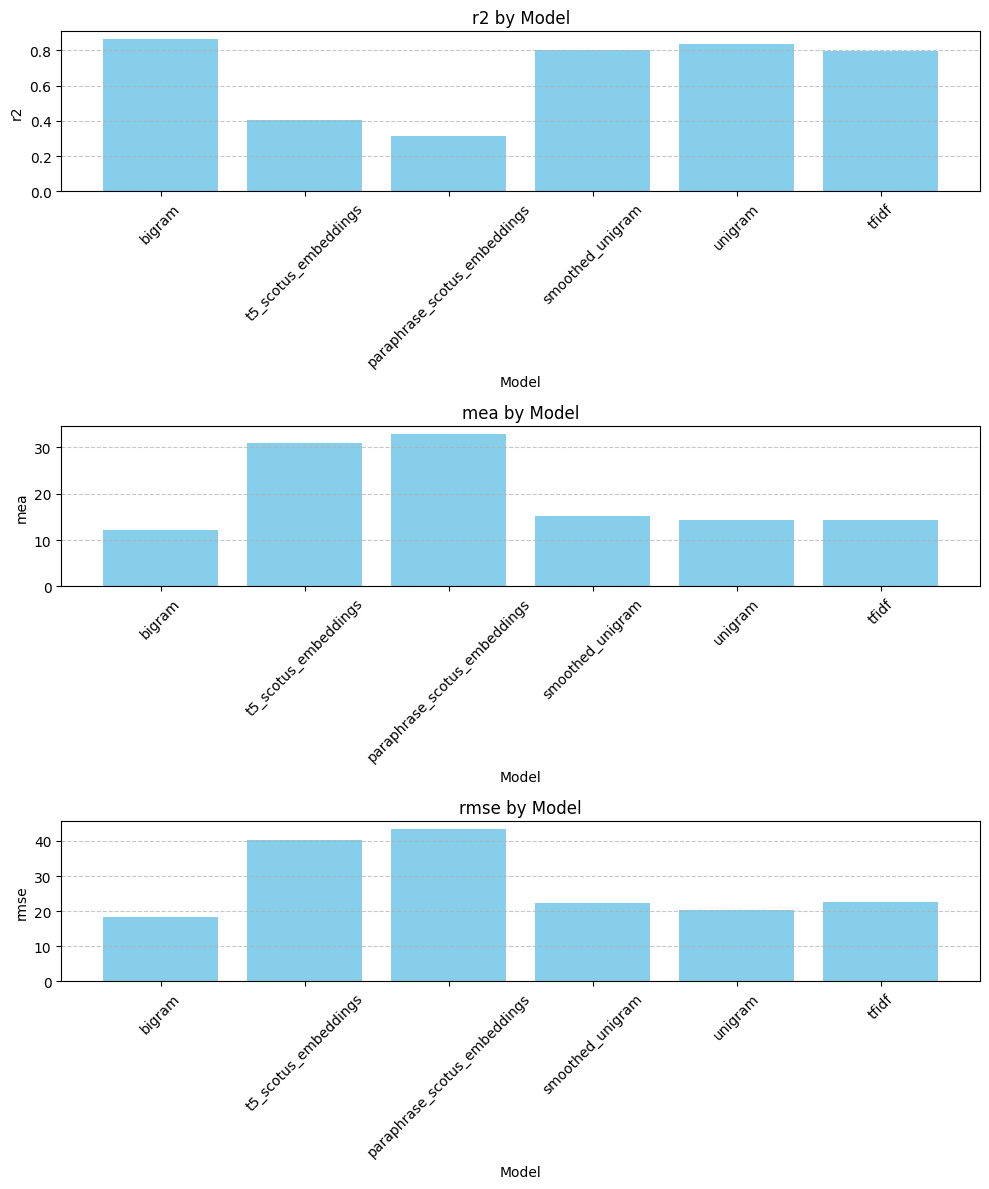

In [47]:
models = scores_df["model_name"]
scores = scores_df.iloc[:, 1:]  # All score columns
score_columns = scores.columns

# Bar width and positions
bar_width = 0.2
x = np.arange(len(models))  # Position of models on x-axis

plt.figure(figsize=(10, 12))

for i, (score_name, score_values) in enumerate(scores.items(), start=1):
    plt.subplot(3, 1, i)  # Create a subplot for each score
    plt.bar(models, score_values, color="skyblue")
    plt.title(f"{score_name} by Model")
    plt.xlabel("Model")
    plt.ylabel(score_name)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
# Adjust layout
plt.tight_layout()
plt.show()